## Introduction

This notebook shows the 2D detection of vehicles from images.

We use the [YOLOv3 pytorch implementation](https://github.com/eriklindernoren/PyTorch-YOLOv3/tree/master) from [Erik Linder-Noren](https://github.com/eriklindernoren) as the detection model.

[ydixon/yolo_v3](https://github.com/ydixon/yolo_v3) gives a more detailed study of the implementation detail of YOLOv3.

The TensorFlow implementation of YOLOv3 is [here](https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/) and [here again](https://www.kaggle.com/code/sakshaymahna/yolov3-keras-2d-object-detection/notebook).

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.patches as patches
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import io, transform

import torchvision.transforms as transforms
from torch.utils.data import Dataset

## 3rd-party PyTorch YOLOv3 implementation

In [ ]:
# use the "--user" flag to bypasses the need for root access by installing the package for the current user.
!pip3 install pytorchyolo --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 20.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 111.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Conside

In [ ]:
# returns version and installation path.
!pip3 -V

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
# list locations of an installed packages "pytorchyolo"
!pip list -v | grep pytorchyolo

pytorchyolo                      1.8.0                 /root/.local/lib/python3.10/site-packages pip


In [ ]:
# path where python looks for packages.
import sys
import sysconfig

print(sysconfig.get_paths()["purelib"])
print(sys.path)

# add "pytorchyolo" path to python path
sys.path.append('/root/.local/lib/python3.10/site-packages')

/usr/local/lib/python3.10/dist-packages
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
from pytorchyolo.utils.utils import load_classes, rescale_boxes, non_max_suppression, print_environment_info

## An Detection Example

### Download model weights

In [ ]:
# Download weights for vanilla YOLOv3
!mkdir -p ./data
!wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com" -P ./data

--2023-10-09 06:25:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  61.4MB/s    in 4.1s    

2023-10-09 06:25:11 (57.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# # Download weights for tiny YOLOv3
!mkdir -p ./data
!wget -c "https://pjreddie.com/media/files/yolov3-tiny.weights" --header "Referer: pjreddie.com" -P ./data

--2023-10-10 04:15:54--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘./data/yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  27.4MB/s    in 1.2s    

2023-10-10 04:15:56 (27.4 MB/s) - ‘./data/yolov3-tiny.weights’ saved [35434956/35434956]



In [ ]:
# Download weights for backbone network
!mkdir -p ./data
!wget -c "https://pjreddie.com/media/files/darknet53.conv.74" --header "Referer: pjreddie.com" -P ./data

### Download (and upload) config files

In [ ]:
# Download the configuration file and put it in the directory "./data"
# https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/master/config/yolov3.cfg
# https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/master/config/yolov3-tiny.cfg

### Create a Model for Detection

In [ ]:
from pytorchyolo import detect, models

In [ ]:
model = models.load_model('./data/yolov3-tiny.cfg',
                          './data/yolov3-tiny.weights')

In [ ]:
def read_image(image_file, target_shape, plot=False):
  image = io.imread(image_file)
  image_height, image_width, _ = image.shape # H, W, C
  image_sz = cv2.resize(image, target_shape)
  # image_sz = image_sz.astype("double")
  # image_sz /= 255

  if plot:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image_sz)
    plt.show()
    print(f'original image shape: {image.shape}')
    print(f'resized image shape: {image_sz.shape}')

  # image_sz = np.expand_dims(image_sz, 0)
  return image_sz, image_height, image_width

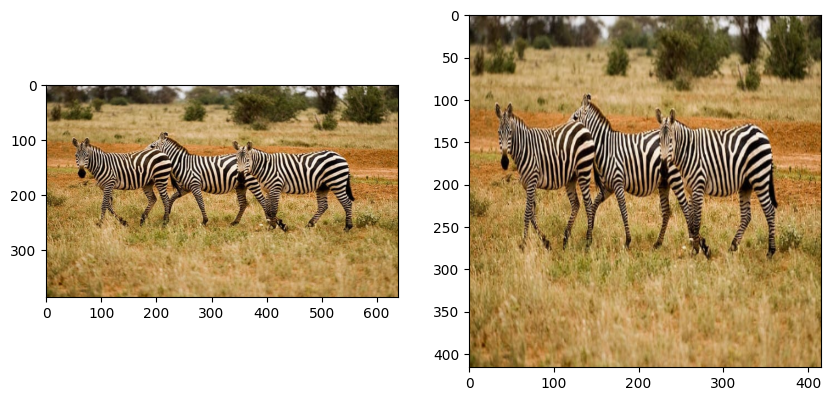

original image shape: (386, 640, 3)
resized image shape: (416, 416, 3)


In [ ]:
image_file = './data/zebra.jpg'
input_width, input_height = 416, 416
image, image_height, image_width = read_image(image_file, (input_width, input_height), plot=True)

In [ ]:
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS

image = io.imread(image_file)
input_img = transforms.Compose([
        DEFAULT_TRANSFORMS,
        Resize((input_width, input_height))])(
            (image, np.zeros((1, 5))))[0].unsqueeze(0)
image.shape, input_img.shape, input_width, input_height

((386, 640, 3), torch.Size([1, 3, 416, 416]), 416, 416)

In [ ]:
# make prediction
detections = model(input_img)
detections = non_max_suppression(detections, 0.5, 0.5)
detections = rescale_boxes(detections[0], 416, image.shape[:2])

# summarize the shape of the list of arrays
print(detections)

tensor([[320.0626, 102.8179, 579.8864, 269.7170,   0.9751,  22.0000],
        [175.0952,  93.6211, 376.2612, 270.6837,   0.8933,  22.0000],
        [ 47.6374, 100.1767, 207.3648, 264.3407,   0.8000,  22.0000]])


In [ ]:
def _draw_image(image_path, detections, img_size, classes):
    """Draws detections in output image and stores this.

    :param image_path: Path to input image
    :type image_path: str
    :param detections: List of detections on image
    :type detections: [Tensor]
    :param img_size: Size of each image dimension for yolo
    :type img_size: int
    :param classes: List of class names
    :type classes: [str]
    """
    # Create plot
    img = io.imread(image_path)
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Rescale boxes to original image
    # detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:,-1].cpu().unique()
    n_cls_preds = len(unique_labels)
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_preds)]
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_pred in detections:

        print(f"\t+ Label: {classes[int(cls_pred)]} | Confidence: {conf.item():0.4f}")

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=f"{classes[int(cls_pred)]}: {conf:.2f}",
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0})

    # Save generated image with detections
    plt.axis("off")
    plt.show()
    # plt.gca().xaxis.set_major_locator(NullLocator())
    # plt.gca().yaxis.set_major_locator(NullLocator())
    # filename = os.path.basename(image_path).split(".")[0]
    # output_path = os.path.join(output_path, f"{filename}.png")
    # plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    # plt.close()

In [ ]:
# COCO labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

	+ Label: zebra | Confidence: 0.9751
	+ Label: zebra | Confidence: 0.8933
	+ Label: zebra | Confidence: 0.8000


<Figure size 640x480 with 0 Axes>

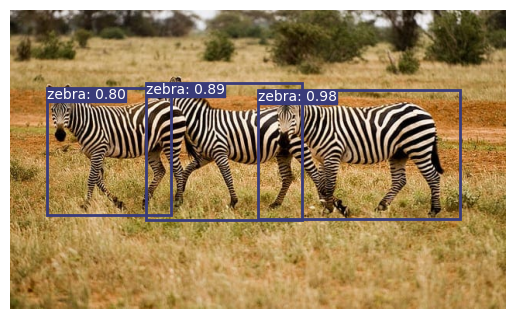

In [ ]:
_draw_image(image_file, detections, 416, labels)

## Dataset

We use the [COCO](https://cocodataset.org/) as our dataset, and select "person", "bicycle", "car" as objects of interest. We will re-train the pre-trained YOLOv3 model on these three object categories and see if we can achieve improved results on them.

The dataset is place in the directory `./data/coco`, and is organized as follows:
```
coco/
├── annotations/
│   ├── instances_train2017.json
├── images/
│   ├── val2017/
│       ├── 000000000009.jpg
│       ├── ...
```

In [ ]:
!mkdir -p ./data/coco
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P ./data/coco
!unzip ./data/coco/annotations_trainval2017.zip -d ./data/coco

!mkdir -p ./data/coco/images
!wget -c http://images.cocodataset.org/zips/val2017.zip -P ./data/coco/images
!unzip ./data/coco/images/val2017.zip -d ./data/coco/images

Archive:  ./data/coco/annotations_trainval2017.zip
  inflating: ./data/coco/annotations/instances_train2017.json  
  inflating: ./data/coco/annotations/instances_val2017.json  
  inflating: ./data/coco/annotations/captions_train2017.json  
  inflating: ./data/coco/annotations/captions_val2017.json  
  inflating: ./data/coco/annotations/person_keypoints_train2017.json  
  inflating: ./data/coco/annotations/person_keypoints_val2017.json  


In [ ]:
from pycocotools.coco import COCO

In case if the `COCO API` is not installed, use the following commands below to install the COCO API.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
%cd /content/cocoapi/PythonAPI/
!make
%cd /content

In [ ]:
from pycocotools.coco import COCO

dataDir = './data/coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco = COCO(annFile)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


In [ ]:
import glob
files = sorted(glob.glob("%s/images/%s/*.*" % (dataDir, dataType)))
len(files), files[0]

(5000, './data/coco/images/val2017/000000000139.jpg')

In [ ]:
import json

# Opening JSON file
f = open(annFile)

# returns JSON object as
# a dictionary
data = json.load(f)

# Iterating through the json
# list
for k in list(data.keys()):
    print(k)

# Closing file
f.close()

info
licenses
images
annotations
categories


In [ ]:
# display COCO categories and supercategories
categories = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in categories]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in categories])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
vehicle kitchen food animal outdoor appliance sports furniture accessory indoor electronic person


In [ ]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds);
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img

{'license': 1,
 'file_name': '000000324158.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000324158.jpg',
 'height': 334,
 'width': 500,
 'date_captured': '2013-11-19 23:54:06',
 'flickr_url': 'http://farm1.staticflickr.com/169/417836491_5bf8762150_z.jpg',
 'id': 324158}

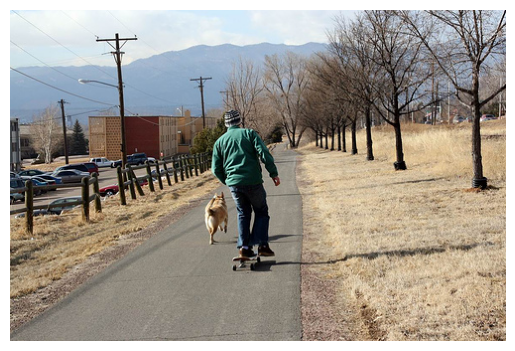

In [ ]:
# load and display image
image = io.imread(img['coco_url']) # use url to load image
plt.axis('off')
plt.imshow(image)
plt.show()

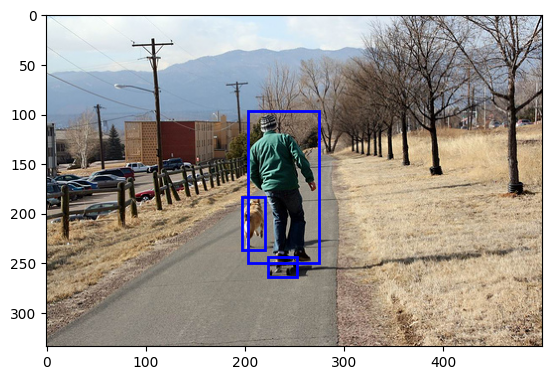

3


In [ ]:
# plot detection bboxes.
import matplotlib.patches as patches

annotation_ids = coco.getAnnIds(imgIds=324158, catIds=catIds)
anns = coco.loadAnns(annotation_ids)

fig, ax = plt.subplots()
for ann in anns:
  box = ann['bbox']
  bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor="blue", facecolor="none")
  ax.add_patch(bb)

ax.imshow(image)
plt.show()
print(len(annotation_ids))

In [ ]:
# compute some stats of the datasets
# distribution of four categories: person, car, bicycle, and others

In [ ]:
class CocoDataset(Dataset):
  def __init__(self, data_folder, mode, transform, target_transform):
    self.files = sorted(glob.glob("%s/*.*" % data_folder))
    self.mode = mode
    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, index):
    img_path = self.files[index % len(self.files)]
    img = np.array(io.imread(img_path), dtype=np.uint8)

    # Label Placeholder
    boxes = np.zeros((1, 5))

    # Apply transforms
    if self.transform:
        img, _ = self.transform((img, boxes))

    return img_path, img

    def __len__(self):
        return len(self.files)

## Data Loader